# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Размер train: {train.shape}")
print(f"Размер test: {test.shape}")

display(train.head())


Размер train: (15000, 24)
Размер test: (10000, 23)


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,70.0,92.0,184.0,49.0,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,65.0,89.0,201.0,75.0,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,70.0,89.0,203.0,72.0,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,61.0,91.0,168.0,78.0,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,79.0,88.0,215.0,87.0,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0


In [ ]:
print(train.info())

missing = train.isnull().sum()
print("Пропуски:\n", missing[missing > 0])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

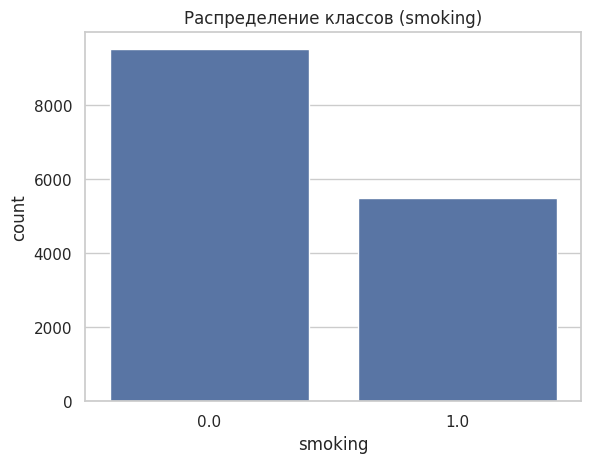

Доля курящих: 0.3666


In [ ]:
sns.countplot(x='smoking', data=train)
plt.title('Распределение классов (smoking)')
plt.show()

print("Доля курящих:", train['smoking'].mean())


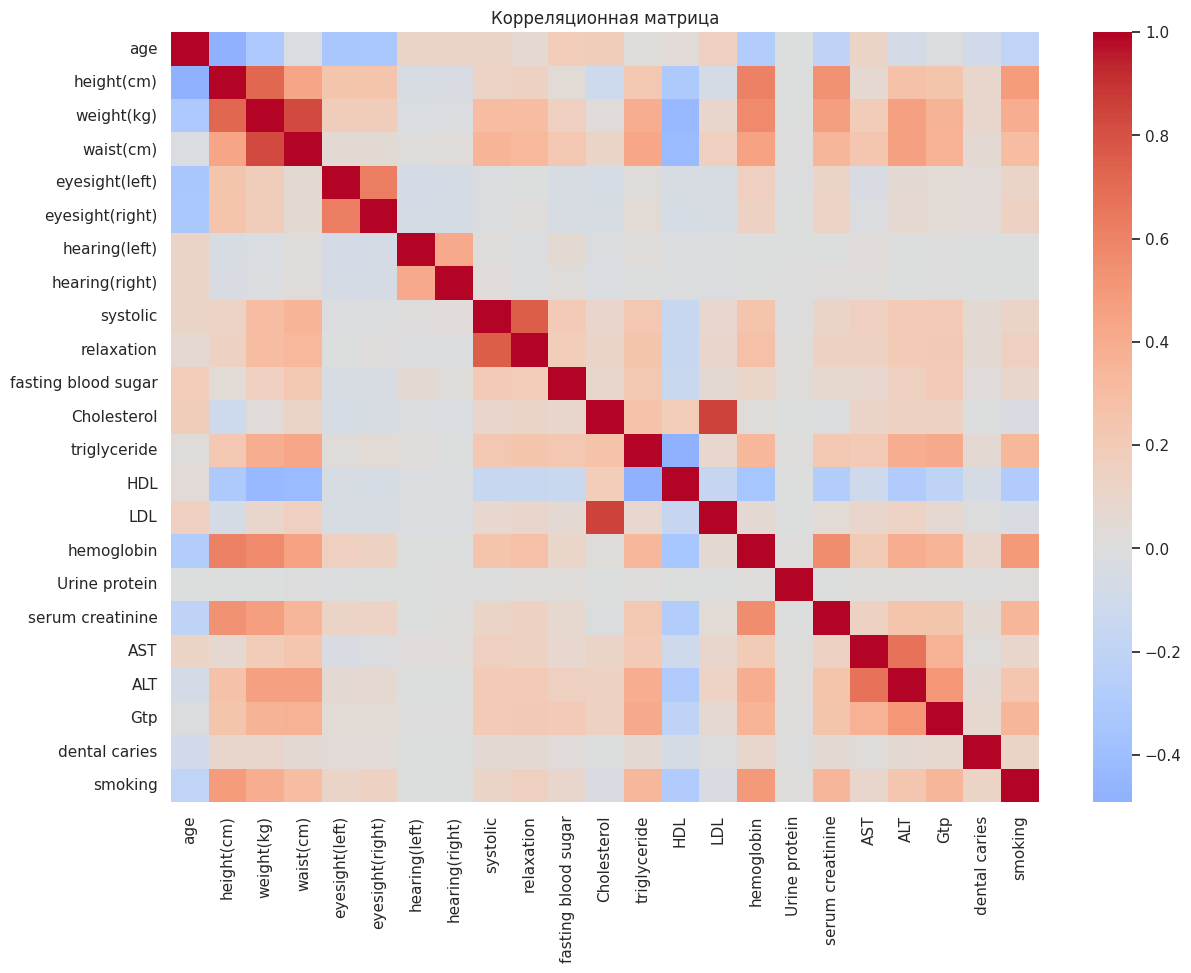

In [ ]:
plt.figure(figsize=(14, 10))
corr_matrix = train.drop(columns=['id']).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title("Корреляционная матрица")
plt.show()


Сильная положительная корреляция между: Cholesterol, LDL, Triglyceride, также weight и waist(cm) и между AST, ALT, Gtp.

У признака smoking умеренная отрицательная корреляция с eyesight, а также слабые положительные связи с waist, fasting blood sugar и Gtp

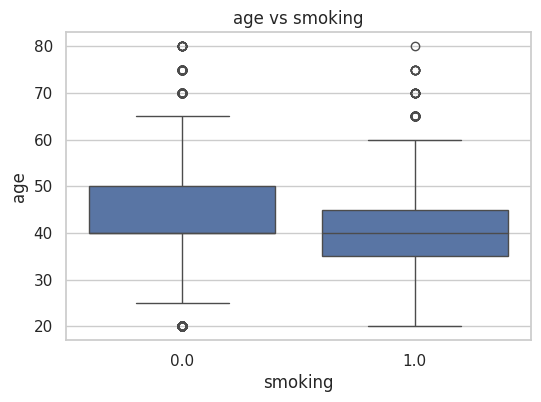

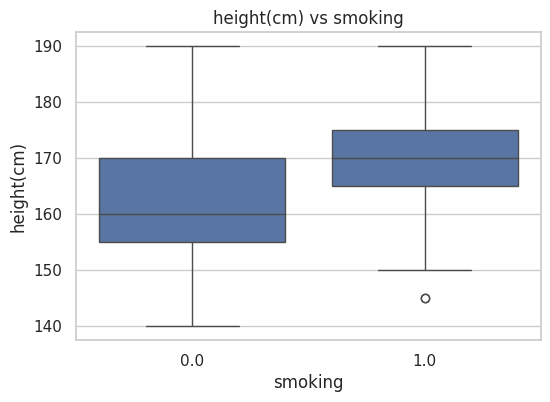

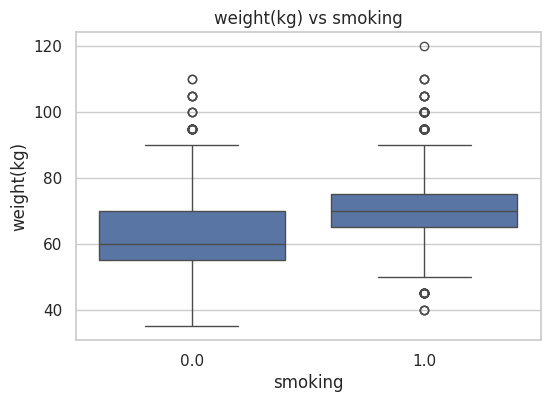

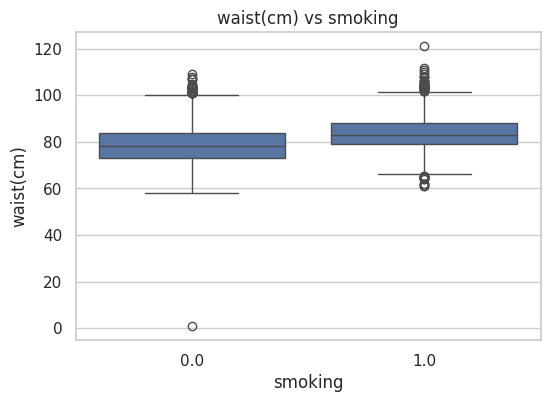

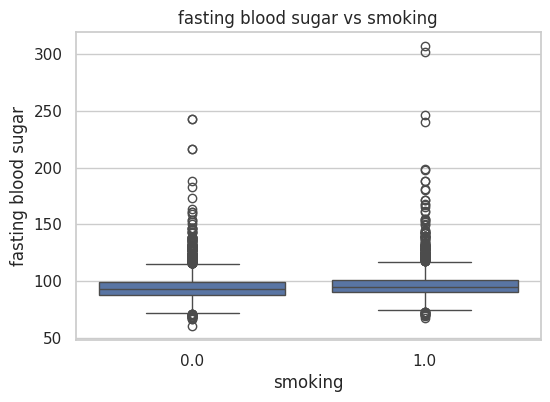

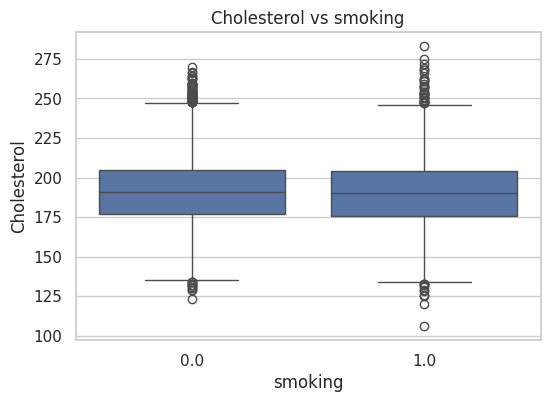

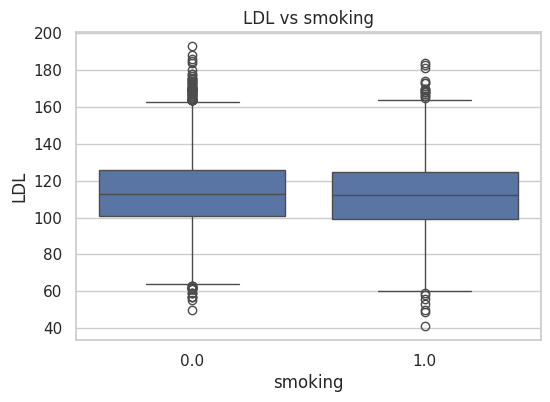

In [ ]:
features_to_plot = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'fasting blood sugar', 'Cholesterol', 'LDL']

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='smoking', y=feature, data=train)
    plt.title(f"{feature} vs smoking")
    plt.show()


In [ ]:
train_data = train.drop(columns=['id'])
test_ids = test['id']
test_data = test.drop(columns=['id'])

X = train_data.drop(columns=['smoking'])
y = train_data['smoking']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
test_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


курящих меньше, чем некурящих.
обнаружены сильные корреляции между холестериновыми показателями (HDL, LDL, Cholesterol).

# Бэггинг

In [ ]:
import numpy as np
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

class MyBaggingClassifier:
    def __init__(self, base_model, n_estimators=10, random_state=None):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.models = []
        n_samples = X.shape[0]

        for i in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X.iloc[indices], y.iloc[indices]

            model = clone(self.base_model)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict_proba(self, X):
        preds = np.array([model.predict_proba(X)[:, 1] for model in self.models])
        return np.mean(preds, axis=0)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)


сравнение со sklearn.ensemble.BaggingClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

my_bagging = MyBaggingClassifier(base_model=DecisionTreeClassifier(), n_estimators=10, random_state=42)
my_bagging.fit(X_train, y_train)
y_pred_my = my_bagging.predict_proba(X_valid)
roc_my = roc_auc_score(y_valid, y_pred_my)
print(f"My Bagging ROC-AUC: {roc_my:.4f}")

sk_bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
sk_bagging.fit(X_train, y_train)
y_pred_sk = sk_bagging.predict_proba(X_valid)[:, 1]
roc_sk = roc_auc_score(y_valid, y_pred_sk)
print(f"Sklearn Bagging ROC-AUC: {roc_sk:.4f}")


My Bagging ROC-AUC: 0.8500
Sklearn Bagging ROC-AUC: 0.8428


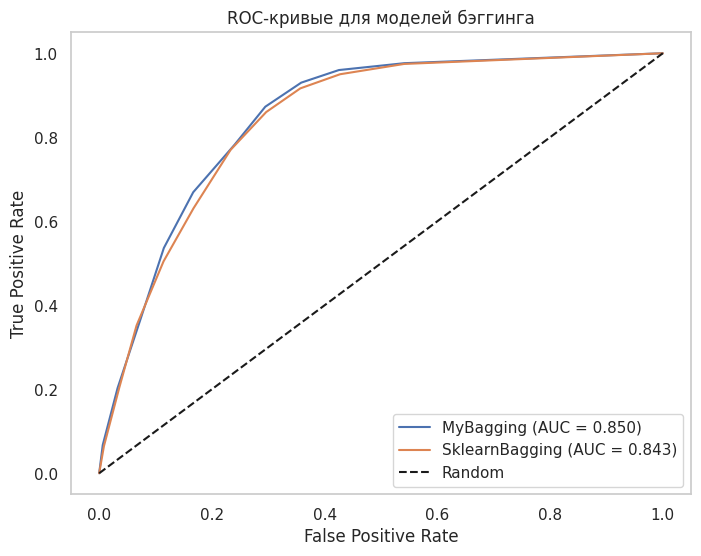

In [ ]:
from sklearn.metrics import roc_curve

# ROC-кривые
fpr_my, tpr_my, _ = roc_curve(y_valid, y_pred_my)
fpr_sk, tpr_sk, _ = roc_curve(y_valid, y_pred_sk)

plt.figure(figsize=(8, 6))
plt.plot(fpr_my, tpr_my, label=f'MyBagging (AUC = {roc_my:.3f})')
plt.plot(fpr_sk, tpr_sk, label=f'SklearnBagging (AUC = {roc_sk:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для моделей бэггинга')
plt.legend()
plt.grid()
plt.show()


обучается корректно

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_label_my = (y_pred_my >= 0.5).astype(int)
y_label_sk = (y_pred_sk >= 0.5).astype(int)

def print_metrics(name, y_true, y_pred):
    print(f"{name}")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print()

print_metrics("My Bagging", y_valid, y_label_my)
print_metrics("Sklearn Bagging", y_valid, y_label_sk)


My Bagging
Accuracy : 0.7680
Precision: 0.6533
Recall   : 0.7827
F1 Score : 0.7122

Sklearn Bagging
Accuracy : 0.7680
Precision: 0.6566
Recall   : 0.7700
F1 Score : 0.7088



# Градиентный бустинг

In [ ]:
import numpy as np
from sklearn.base import clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss

class MyGradientBoostingClassifier:
    def __init__(self, base_model=DecisionTreeRegressor(max_depth=3), n_estimators=100, learning_rate=0.1):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.bias = 0

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.models = []
        Fm = np.full(y.shape, np.log(y.mean() / (1 - y.mean())))

        for m in range(self.n_estimators):
            p = self.sigmoid(Fm)
            grad = y - p

            model = clone(self.base_model)
            model.fit(X, grad)
            self.models.append(model)

            update = model.predict(X)
            Fm += self.learning_rate * update

        self.bias = Fm

    def predict_proba(self, X):
        Fm = np.zeros(X.shape[0])
        for model in self.models:
            Fm += self.learning_rate * model.predict(X)
        return self.sigmoid(Fm)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

my_gb = MyGradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
my_gb.fit(X_train, y_train)
y_pred_my = my_gb.predict_proba(X_valid)
roc_my = roc_auc_score(y_valid, y_pred_my)
print(f"My Gradient Boosting ROC-AUC: {roc_my:.4f}")

sk_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
sk_gb.fit(X_train, y_train)
y_pred_sk = sk_gb.predict_proba(X_valid)[:, 1]
roc_sk = roc_auc_score(y_valid, y_pred_sk)
print(f"Sklearn Gradient Boosting ROC-AUC: {roc_sk:.4f}")

My Gradient Boosting ROC-AUC: 0.8659
Sklearn Gradient Boosting ROC-AUC: 0.8802


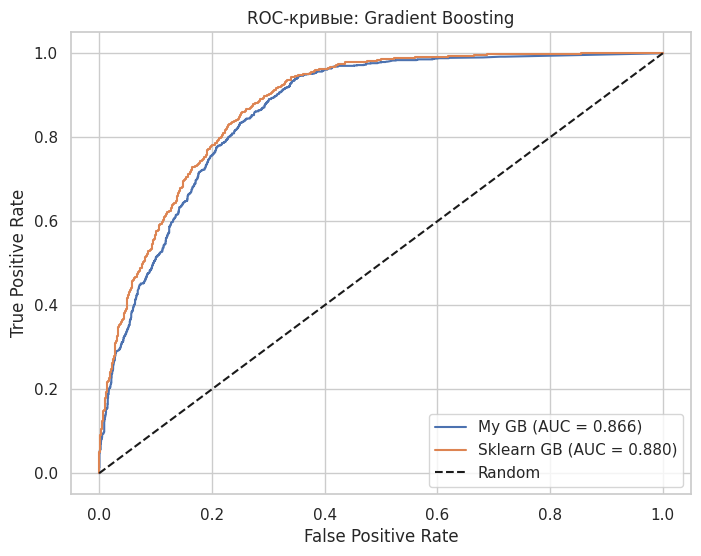

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_my, tpr_my, _ = roc_curve(y_valid, y_pred_my)
fpr_sk, tpr_sk, _ = roc_curve(y_valid, y_pred_sk)

plt.figure(figsize=(8, 6))
plt.plot(fpr_my, tpr_my, label=f"My GB (AUC = {roc_my:.3f})")
plt.plot(fpr_sk, tpr_sk, label=f"Sklearn GB (AUC = {roc_sk:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые: Gradient Boosting")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_valid)[:, 1]
roc_xgb = roc_auc_score(y_valid, y_pred_xgb)

lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict_proba(X_valid)[:, 1]
roc_lgbm = roc_auc_score(y_valid, y_pred_lgbm)

cat = CatBoostClassifier(n_estimators=100, learning_rate=0.1, verbose=0)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict_proba(X_valid)[:, 1]
roc_cat = roc_auc_score(y_valid, y_pred_cat)

print(f"XGBoost ROC-AUC:     {roc_xgb:.4f}")
print(f"LightGBM ROC-AUC:    {roc_lgbm:.4f}")
print(f"CatBoost ROC-AUC:    {roc_cat:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4399, number of negative: 7601
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.366583 -> initscore=-0.546903
[LightGBM] [Info] Start training from score -0.546903
XGBoost ROC-AUC:     0.8769
LightGBM ROC-AUC:    0.8748
CatBoost ROC-AUC:    0.8820


Наилучший результат достигает CatBoost, будем использовать его для финального предсказания


# Подобрать оптимальные гиперпараметры для лучшей модели с помощью Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'iterations': 100,
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0.0, 1.0),
        'random_state': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    return roc_auc_score(y_valid, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC:", study.best_value)

[I 2025-05-25 10:30:04,809] A new study created in memory with name: no-name-ace062c2-debb-43b2-8322-dca84323bc04
[I 2025-05-25 10:30:06,322] Trial 0 finished with value: 0.8786167464114834 and parameters: {'learning_rate': 0.08453259609651566, 'depth': 4, 'l2_leaf_reg': 1.1973114743295674, 'bagging_temperature': 0.6810933832047734}. Best is trial 0 with value: 0.8786167464114834.
[I 2025-05-25 10:30:08,453] Trial 1 finished with value: 0.8780569377990429 and parameters: {'learning_rate': 0.06028123503190678, 'depth': 5, 'l2_leaf_reg': 0.0018448036116236132, 'bagging_temperature': 0.5017807242470141}. Best is trial 0 with value: 0.8786167464114834.
[I 2025-05-25 10:30:11,565] Trial 2 finished with value: 0.8727832535885168 and parameters: {'learning_rate': 0.011068021185713527, 'depth': 9, 'l2_leaf_reg': 0.09953268299142172, 'bagging_temperature': 0.5555440101380669}. Best is trial 0 with value: 0.8786167464114834.
[I 2025-05-25 10:30:12,513] Trial 3 finished with value: 0.879164114832

Лучшие параметры: {'learning_rate': 0.08038703244843177, 'depth': 7, 'l2_leaf_reg': 0.3503914256893119, 'bagging_temperature': 0.6079567035094352}
Лучший ROC-AUC: 0.8821397129186602


будем использовать в финальной модели

# Реализовать метрику Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_labels = (y_pred_cat >= 0.5).astype(int)

def my_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

print("Моя Accuracy :", my_accuracy(y_valid, y_pred_labels))
print("Sklearn Accuracy:", accuracy_score(y_valid, y_pred_labels))


Моя Accuracy : 0.798
Sklearn Accuracy: 0.798


результаты совпали

# Реализовать Precision

In [ ]:
from sklearn.metrics import precision_score

def my_precision(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    return TP / (TP + FP + 1e-8)

print("Моя Precision :", my_precision(y_valid, y_pred_labels))
print("Sklearn Precision:", precision_score(y_valid, y_pred_labels))


Моя Precision : 0.696969696964139
Sklearn Precision: 0.696969696969697


# Реализовать Recall

In [ ]:
from sklearn.metrics import recall_score

def my_recall(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    return TP / (TP + FN + 1e-8)

print("Моя Recall :", my_recall(y_valid, y_pred_labels))
print("Sklearn Recall:", recall_score(y_valid, y_pred_labels))


Моя Recall : 0.7945454545382314
Sklearn Recall: 0.7945454545454546


# Реализовать F1-score

In [ ]:
from sklearn.metrics import f1_score

def my_f1(y_true, y_pred):
    prec = my_precision(y_true, y_pred)
    rec = my_recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + 1e-8)

print("Мой F1-score :", my_f1(y_valid, y_pred_labels))
print("Sklearn F1-score:", f1_score(y_valid, y_pred_labels))


Мой F1-score : 0.7425658403846741
Sklearn F1-score: 0.7425658453695837


# AUC-ROC

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def my_auc_roc(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = 0.0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2  # метод трапеций
    return auc

print("My AUC-ROC      :", my_auc_roc(y_valid, y_pred_cat))
print("Sklearn AUC-ROC :", roc_auc_score(y_valid, y_pred_cat))


My AUC-ROC      : 0.882041148325359
Sklearn AUC-ROC : 0.8820411483253588


# AUC-PR

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def my_auc_pr(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc = 0.0
    for i in range(1, len(recall)):
        auc += (recall[i-1] - recall[i]) * (precision[i] + precision[i-1]) / 2  # трапеции по X=recall
    return auc

print("My AUC-PR      :", my_auc_pr(y_valid, y_pred_cat))
print("Sklearn AUC-PR :", average_precision_score(y_valid, y_pred_cat))

My AUC-PR      : 0.7895521315285808
Sklearn AUC-PR : 0.7897114868679375


# Новый раздел

In [ ]:
final_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.08038703244843177,
    depth=7,
    l2_leaf_reg=0.3503914256893119,
    bagging_temperature=0.6079567035094352,
    random_state=42,
    verbose=0
)

final_model.fit(X_scaled, y)

final_preds = final_model.predict_proba(test_scaled)[:, 1]

submission = pd.DataFrame({
    'id': test_ids,
    'smoking': final_preds
})
submission.to_csv("submission.csv", index=False)


In [ ]:
submission.head()


,id,smoking
0,15000,0.022596
1,15001,0.832272
2,15002,0.161229
3,15003,0.734207
4,15004,0.009283
